In [2]:
import math
import unittest

import QuantLib as ql
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, curve_fit, least_squares
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

from scipy.stats import norm

from math import log, exp, sqrt
import plotly.express as px

In [3]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import plotly.graph_objs as go
import time

In [4]:
SABRbeta = 0.5
r = 0.05



In [6]:
def call(S, K, T, sigma):
    F = S / (math.exp(- r * T))
    d1 = (math.log(F / K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = (math.log(F / K) - 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    res = math.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return res
    
    
# the implied volatility according the SABR model
def SABRsigma(S, K, T, alpha, beta, rho, nu):
    X = K
    F = S / (math.exp(- r * T))
    if F is K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F*(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def SABRcall(S, K, T, alpha, beta, rho, nu):
    return call(S, K, T, SABRsigma(S, K, T, alpha, beta, rho, nu))

def call_by_sigma(S, K, T, sigma):
    return call(S, K, T, sigma)

covariance matrix:
 [[ 1.  -0.7]
 [-0.7  1. ]] 
----------------


Text(0.5, 1.0, 'Correlated Random Variables')

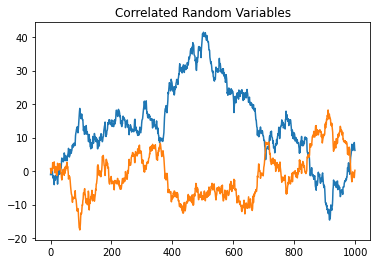

In [16]:
rho = -0.7
Ndraws = 1000


mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])
print('covariance matrix:\n', cov, "\n----------------")

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [17]:
# checking the realized covariance
print(np.corrcoef(W.T))

[[ 1.         -0.72534237]
 [-0.72534237  1.        ]]


In [107]:

def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])

        prices[:, t] = S_t
        sigs[:, t] = v_t
#         paths_S_t.append(S_t)
    
    if return_vol:
        return prices, sigs
    
    return prices

In [91]:
kappa =10
theta = 0.1
v_0 =  0.2
xi = 0.9
r = 0.02
S = 100
paths =100
steps = 200
T = 1

In [118]:
prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)

In [119]:
prices_pos

array([[ 98.69815308,  97.13180445,  92.38682649, ..., 101.21139742,
        100.6909047 ,  97.73964125],
       [ 99.90743489, 103.04597306, 107.60759297, ..., 206.26435402,
        210.68589416, 211.97027847],
       [ 96.8057761 , 101.52338212, 100.6490614 , ...,  95.18053858,
         97.50941041,  96.87444414],
       ...,
       [ 96.4481272 ,  94.51959591,  94.56207221, ...,  73.14274136,
         70.34148207,  68.09949454],
       [ 95.22960476,  96.83199917,  99.4908295 , ...,  63.13199818,
         61.36991865,  63.23735404],
       [102.7931413 , 106.00411303, 109.92791698, ...,  99.56558138,
         97.15543784,  94.28264916]])

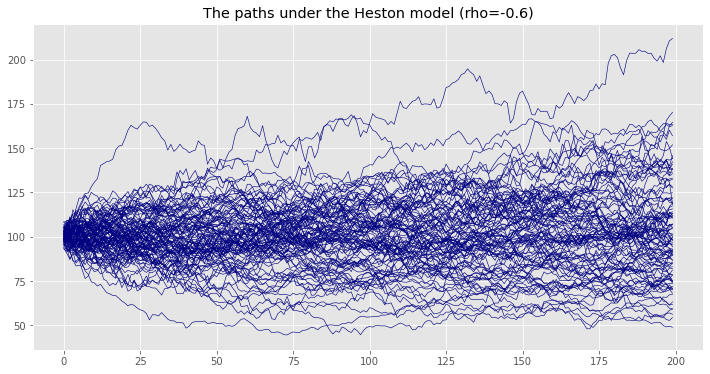

In [120]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))

all_paths = []
Range = np.arange(steps) 

plt.title("The paths under the Heston model (rho=-0.6)")


for i in range(0, paths):
    ax.plot(Range, prices_pos[i])



In [ ]:

def generate_SABR_paths(S, T, r, alpha, beta, rho, nu
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])

        prices[:, t] = S_t
        sigs[:, t] = v_t
#         paths_S_t.append(S_t)
    
    if return_vol:
        return prices, sigs
    
    return prices

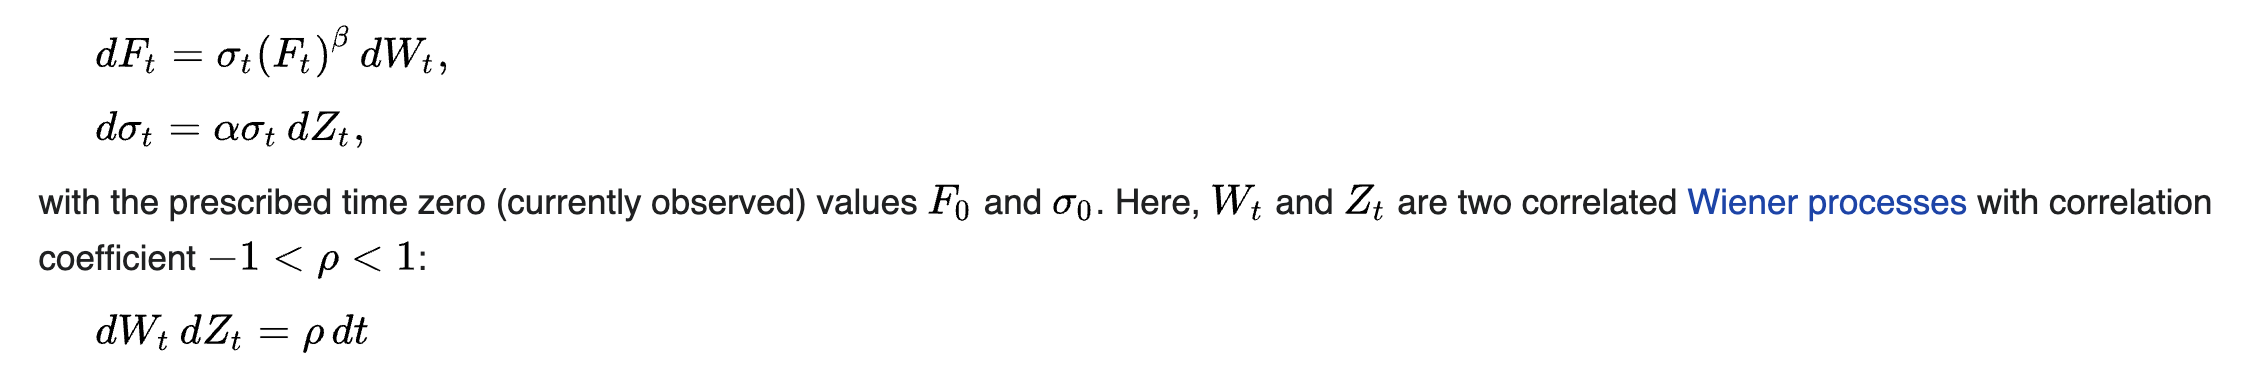

In [124]:
import sympy as sp
import sympy.stats

In [125]:
def sp_SABRsigma(F, K, T, alpha, beta, rho, nu):
    X = K
    z=(nu/alpha)*((F*K)**(0.5*(1-beta)))*sp.log(F/K)
    zhi = sp.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
    numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*K)**(1 - beta)))
    numer2 = 0.25*rho*beta*nu*alpha/((F*K)**((1 - beta)/2))
    numer3 = ((2 - 3*rho*rho)/24)*nu*nu
    numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
    denom1 = ((1 - beta)**2/24)*(sp.log(F/K))**2
    denom2 = (((1 - beta)**4)/1920)*((sp.log(F/K))**4)
    denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
    sabrsigma = numer/denom
    return sabrsigma

def sp_call(F, K, T, sigma):
#     F = S / (math.exp(- r * T))
    d1 = (sp.log(F / K) + 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    d2 = (sp.log(F / K) - 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    res = sp.exp(-r * T) * (F * sp.stats.cdf(n)(d1) - K * sp.stats.cdf(n)(d2))
    return res

In [126]:
F, K, T, alpha, beta, rho, nu, sigma, n = sp.symbols('F K T alpha beta rho nu sigma n')

In [127]:
n = sympy.stats.Normal('n', 0, 1)
sp.stats.cdf(n)(1.96).evalf()

0.975002104851780

In [128]:
sp_sabrcall = sp_call(F,K,T,sigma)
dc_dsigma = sp.diff(sp_sabrcall, sigma)
# dc_dsigma.evalf(subs={'K':38000, 'F':40000, 'T':0.074, 'sigma':0.52})
dc_dsigma

(F*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi) - K*(-0.5*sqrt(2)*sqrt(T) - sqrt(2)*(-0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(-0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi))*exp(-0.02*T)

In [133]:
dc_df = sp.diff(sp_sabrcall, F)
dc_df

(erf(sqrt(2)*(0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma))/2 + 1/2 + sqrt(2)*exp(-(0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/(2*sqrt(pi)*sqrt(T)*sigma) - sqrt(2)*K*exp(-(-0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/(2*sqrt(pi)*F*sqrt(T)*sigma))*exp(-0.02*T)

In [129]:
SABRsigma = sp.simplify(sp_SABRsigma(F, K, T, alpha, beta, rho, nu))
# t1.evalf(subs={F:1,K:2,alpha:1,beta:1,rho:0,nu:1})
# sp.simplify(SABRsigma.evalf(subs={alpha:0.567, beta:0.6712, rho:0.2413, nu:0.89123}))
SABRsigma

80*nu*(T*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**2 + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2) + nu**2*(2 - 3*rho**2)) + 24)*log(F/K)/(((beta - 1)**4*log(F/K)**4 + 80*(beta - 1)**2*log(F/K)**2 + 1920)*log((alpha*(rho - ((alpha**2 - 2*alpha*nu*rho*(F*K)**(0.5 - 0.5*beta)*log(F/K) + nu**2*(F*K)**(1.0 - 1.0*beta)*log(F/K)**2)/alpha**2)**0.5) - nu*(F*K)**(0.5 - 0.5*beta)*log(F/K))/(alpha*(rho - 1))))

In [130]:
dc_dsigma

(F*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi) - K*(-0.5*sqrt(2)*sqrt(T) - sqrt(2)*(-0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(-0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi))*exp(-0.02*T)

In [134]:
dsigma_df = (sp.diff(SABRsigma, F))
# dsigma_df.evalf(subs={'alpha': x[0], 'beta': 0.5, 'rho': x[1], 'nu':x[2], 'K':38000, 'F':40000, 'T':0.074})
dsigma_df

80*T*nu*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**3/F + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2)*(beta/2 - 1/2)/F)*log(F/K)/(((beta - 1)**4*log(F/K)**4 + 80*(beta - 1)**2*log(F/K)**2 + 1920)*log((alpha*(rho - ((alpha**2 - 2*alpha*nu*rho*(F*K)**(0.5 - 0.5*beta)*log(F/K) + nu**2*(F*K)**(1.0 - 1.0*beta)*log(F/K)**2)/alpha**2)**0.5) - nu*(F*K)**(0.5 - 0.5*beta)*log(F/K))/(alpha*(rho - 1)))) + 80*nu*(T*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**2 + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2) + nu**2*(2 - 3*rho**2)) + 24)*(-4*(beta - 1)**4*log(F/K)**3/F - 160*(beta - 1)**2*log(F/K)/F)*log(F/K)/(((beta - 1)**4*log(F/K)**4 + 80*(beta - 1)**2*log(F/K)**2 + 1920)**2*log((alpha*(rho - ((alpha**2 - 2*alpha*nu*rho*(F*K)**(0.5 - 0.5*beta)*log(F/K) + nu**2*(F*K)**(1.0 - 1.0*beta)*log(F/K)**2)/alpha**2)**0.5) - nu*(F*K)**(0.5 - 0.5*beta)*log(F/K))/(alpha*(rho - 1)))) - 80*nu*(T*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**2 + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2) + nu**2*(2 - 3*rho**2)) + 24)*(-0.5*alp

In [136]:
sabr_delta = dc_df + dc_dsigma * dsigma_df
sabr_delta

(F*(0.5*sqrt(2)*sqrt(T) - sqrt(2)*(0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi) - K*(-0.5*sqrt(2)*sqrt(T) - sqrt(2)*(-0.5*T*sigma**2 + log(F/K))/(2*sqrt(T)*sigma**2))*exp(-(-0.5*T*sigma**2 + log(F/K))**2/(2*T*sigma**2))/sqrt(pi))*(80*T*nu*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**3/F + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2)*(beta/2 - 1/2)/F)*log(F/K)/(((beta - 1)**4*log(F/K)**4 + 80*(beta - 1)**2*log(F/K)**2 + 1920)*log((alpha*(rho - ((alpha**2 - 2*alpha*nu*rho*(F*K)**(0.5 - 0.5*beta)*log(F/K) + nu**2*(F*K)**(1.0 - 1.0*beta)*log(F/K)**2)/alpha**2)**0.5) - nu*(F*K)**(0.5 - 0.5*beta)*log(F/K))/(alpha*(rho - 1)))) + 80*nu*(T*(alpha**2*(F*K)**(beta - 1)*(beta - 1)**2 + 6.0*alpha*beta*nu*rho*(F*K)**(beta/2 - 1/2) + nu**2*(2 - 3*rho**2)) + 24)*(-4*(beta - 1)**4*log(F/K)**3/F - 160*(beta - 1)**2*log(F/K)/F)*log(F/K)/(((beta - 1)**4*log(F/K)**4 + 80*(beta - 1)**2*log(F/K)**2 + 1920)**2*log((alpha*(rho - ((alpha**2 - 2*alpha*nu

In [148]:
x = [6, 0.7, 100]

In [150]:
sabr_delta.evalf(subs={'alpha': x[0], 'beta': 0.5, 'rho': x[1], 'nu':x[2], 'K':3800, 'F':3500, 'T':0.2})


475.302314164008*(-0.316227766016838 - 1.58113883008419*(-0.1*sigma**2 - 0.0822380982369721)/sigma**2)*exp(-2.5*(-0.1*sigma**2 + log(35/38))**2/sigma**2) - 437.778447256323*(0.316227766016838 - 1.58113883008419*(0.1*sigma**2 - 0.0822380982369721)/sigma**2)*exp(-2.5*(0.1*sigma**2 + log(35/38))**2/sigma**2) + 0.498003994671996*erf(1.11803398874989*sqrt(2)*(0.1*sigma**2 + log(35/38))/sigma) + 0.498003994671996 + 0.888500936834724*exp(-2.5*(0.1*sigma**2 + log(35/38))**2/sigma**2)/sigma - 0.964658159991986*exp(-2.5*(-0.1*sigma**2 + log(35/38))**2/sigma**2)/sigma

In [143]:
sp_sabrcall.evalf(subs={'alpha': x[0], 'beta': 0.5, 'rho': x[1], 'nu':x[2], 'K':38000, 'F':40000, 'T':0.074})


-18971.9007985381*erf(1.83803655523452*sqrt(2)*(-0.037*sigma**2 + log(20/19))/sigma) + 19970.421893198*erf(1.83803655523452*sqrt(2)*(0.037*sigma**2 + log(20/19))/sigma) + 998.521094659901